# Fine-Tuning DistilBERT for Question Answering

---

## 🎯 Scenario

Your startup is building a Q&A assistant to help users find information quickly. Pretrained DistilBERT understands general English but doesn't know how to extract precise answer spans from passages. In this demo, we'll **fine-tune** DistilBERT on Q&A pairs so it learns to locate answers in context while leveraging its pretrained language understanding.

## 🔑 Key Question

**How can we adapt a pretrained model to a specific task with limited data?**

---

## 💡 What You'll Learn

- **Transfer learning workflow**: Pretrained weights → task-specific head → fine-tuning
- **HuggingFace Trainer**: High-level API for training loop, logging, and checkpoints
- **Learning rate considerations**: Why we use lower LR for fine-tuning vs. training from scratch
- **Catastrophic forgetting**: Why we freeze layers or use smaller learning rates
- **Computational efficiency**: Fine-tuning with 1,000 examples vs. pretraining with billions

---

## Setup & Introduction

Let's start by importing our libraries and setting up the environment.

In [1]:
# Import required libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    TrainingArguments,
    Trainer,
    default_data_collator
)
import warnings
warnings.filterwarnings('ignore')

# Import our custom utilities
from qa_utils import (
    create_squad_subset,
    prepare_train_features,
    prepare_validation_features,
    postprocess_qa_predictions,
    compute_exact_match,
    compute_f1_score,
    plot_training_metrics,
    compare_predictions,
    print_training_summary
)

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

print("✅ Libraries imported successfully!")
print(f"🔧 PyTorch version: {torch.__version__}")
print(f"💻 Device: {'GPU (CUDA)' if torch.cuda.is_available() else 'CPU'}")

✅ Libraries imported successfully!
🔧 PyTorch version: 2.9.1
💻 Device: CPU


---

## Load Pretrained DistilBERT

DistilBERT is a smaller, faster version of BERT that retains most of BERT's language understanding while being significantly smaller and faster. It was pretrained on massive text corpora to understand general language patterns.

We'll load `distilbert-base-uncased` and add a **Question Answering head** on top.

In [2]:
# Model and tokenizer names
MODEL_NAME = "distilbert-base-uncased"

# Load pretrained tokenizer
print("📥 Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Load pretrained model with Q&A head
print("📥 Loading pretrained model...")
model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)

print("\n✅ Model loaded successfully!")
print(f"\n📊 Model Statistics:")
print(f"  • Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  • Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Show model summary
print("\n🔍 Model Components:")
for name, module in model.named_children():
    params = sum(p.numel() for p in module.parameters())
    print(f"  • {name}: {params:,} parameters")

📥 Loading tokenizer...
📥 Loading pretrained model...📥 Loading pretrained model...

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




✅ Model loaded successfully!

📊 Model Statistics:
  • Total parameters: 66,364,418
  • Trainable parameters: 66,364,418

🔍 Model Components:
  • distilbert: 66,362,880 parameters
  • qa_outputs: 1,538 parameters
  • dropout: 0 parameters


---

## Load and Prepare SQuAD Dataset

**SQuAD (Stanford Question Answering Dataset)** contains questions about Wikipedia passages. The answer to each question is a span of text from the passage.

We'll:
- Load SQuAD 2.0 from HuggingFace
- Filter out "impossible" questions (those with no answer)
- Create manageable training and test subsets

In [3]:
# Load SQuAD 2.0
print("📥 Loading SQuAD 2.0 dataset...")
dataset = load_dataset("squad_v2")

print(f"\n📊 Original dataset size:")
print(f"  • Training: {len(dataset['train']):,} examples")
print(f"  • Validation: {len(dataset['validation']):,} examples")

# Create subsets (filter impossible questions)
print("\n🔄 Creating subsets (filtering impossible questions)...")
train_subset = create_squad_subset(
    dataset['train'], 
    n_samples=1000, 
    seed=SEED,
    filter_impossible=True
)
test_subset = create_squad_subset(
    dataset['validation'], 
    n_samples=200, 
    seed=SEED,
    filter_impossible=True
)

print(f"\n✅ Subsets created:")
print(f"  • Training: {len(train_subset)} examples")
print(f"  • Test: {len(test_subset)} examples")

print("\n💡 Why only 1,000 examples?")
print("   Transfer learning lets us achieve strong performance with far less data")
print("   than training from scratch (which needs millions of examples!)")

📥 Loading SQuAD 2.0 dataset...

📊 Original dataset size:
  • Training: 130,319 examples
  • Validation: 11,873 examples

🔄 Creating subsets (filtering impossible questions)...

✅ Subsets created:
  • Training: 1000 examples
  • Test: 200 examples

💡 Why only 1,000 examples?
   Transfer learning lets us achieve strong performance with far less data
   than training from scratch (which needs millions of examples!)

📊 Original dataset size:
  • Training: 130,319 examples
  • Validation: 11,873 examples

🔄 Creating subsets (filtering impossible questions)...

✅ Subsets created:
  • Training: 1000 examples
  • Test: 200 examples

💡 Why only 1,000 examples?
   Transfer learning lets us achieve strong performance with far less data
   than training from scratch (which needs millions of examples!)


### 📖 Let's Look at an Example

Understanding the data structure helps us see what the model needs to learn.

In [4]:
# Show example
example = train_subset[0]

print("📖 Example Question-Answer Pair:\n")
print(f"ID: {example['id']}")
print(f"\nQuestion: {example['question']}")
print(f"\nContext (first 300 chars):\n{example['context'][:300]}...")
print(f"\nAnswer: {example['answers']['text'][0]}")
print(f"Answer starts at character: {example['answers']['answer_start'][0]}")

# Highlight answer in context
answer_start = example['answers']['answer_start'][0]
answer_text = example['answers']['text'][0]
answer_end = answer_start + len(answer_text)

print(f"\n🎯 Answer in context:")
print(f"...{example['context'][max(0, answer_start-50):answer_start]}" + 
      f"[{answer_text}]" + 
      f"{example['context'][answer_end:min(len(example['context']), answer_end+50)]}...")

📖 Example Question-Answer Pair:

ID: 56fa4285f34c681400b0c03b

Question: After cellulose, what component is most plentiful in wood?

Context (first 300 chars):
Aside from water, wood has three main components. Cellulose, a crystalline polymer derived from glucose, constitutes about 41–43%. Next in abundance is hemicellulose, which is around 20% in deciduous trees but near 30% in conifers. It is mainly five-carbon sugars that are linked in an irregular mann...

Answer: hemicellulose
Answer starts at character: 152

🎯 Answer in context:
...e, constitutes about 41–43%. Next in abundance is [hemicellulose], which is around 20% in deciduous trees but near ...


### 🔧 Tokenize Dataset

We need to convert text into tokens that the model understands. Special tokens `[CLS]` and `[SEP]` help the model distinguish between question and context.

In [16]:
# Tokenize datasets
print("🔧 Tokenizing training data...")
tokenized_train = train_subset.map(
    lambda x: prepare_train_features(x, tokenizer),
    batched=True,
    remove_columns=train_subset.column_names,
    desc="Tokenizing training data"
)

print("🔧 Tokenizing test data...")
tokenized_test = test_subset.map(
    lambda x: prepare_validation_features(x, tokenizer),
    batched=True,
    remove_columns=test_subset.column_names,
    desc="Tokenizing test data"
)

print("\n✅ Tokenization complete!")
print(f"\n📊 Tokenized dataset:")
print(f"  • Training samples: {len(tokenized_train)}")
print(f"  • Test samples: {len(tokenized_test)}")

# Show tokenization example
print("\n🔍 Tokenization Example:")
first_item = tokenized_train[0]
print(f"  • Input IDs shape: {len(first_item['input_ids'])} tokens")
print(f"  • Answer span: tokens {first_item['start_positions']} to {first_item['end_positions']}")

🔧 Tokenizing training data...


Tokenizing training data:   0%|          | 0/1000 [00:00<?, ? examples/s]

🔧 Tokenizing test data...


Tokenizing test data:   0%|          | 0/200 [00:00<?, ? examples/s]


✅ Tokenization complete!

📊 Tokenized dataset:
  • Training samples: 1015
  • Test samples: 201

🔍 Tokenization Example:
  • Input IDs shape: 384 tokens
  • Answer span: tokens 49 to 53


---

## Baseline Performance

Before fine-tuning, let's see how the pretrained model performs. Since the Q&A head is randomly initialized, we expect poor performance!

In [6]:
print("🔍 Evaluating baseline (pretrained but not fine-tuned) model...\n")

# Create a simple trainer just for prediction
baseline_trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
)

# Get predictions
print("Making predictions on test set...")
baseline_predictions = baseline_trainer.predict(tokenized_test)

# Post-process to get answer texts
baseline_answers = postprocess_qa_predictions(
    examples=test_subset,
    features=tokenized_test,
    predictions=(baseline_predictions.predictions[0], baseline_predictions.predictions[1])
)

# Prepare references
references = {ex['id']: ex['answers']['text'] for ex in test_subset}

# Calculate metrics
baseline_em = compute_exact_match(baseline_answers, references)
baseline_f1 = compute_f1_score(baseline_answers, references)

print("\n📊 Baseline Performance (Before Fine-Tuning):")
print(f"  • Exact Match (EM): {baseline_em:.1%}")
print(f"  • F1 Score: {baseline_f1:.1%}")

print("\n💡 Why so low?")
print("   The Q&A head is randomly initialized! It doesn't know how to")
print("   identify answer spans yet. Let's fix that with fine-tuning!")

# Store for comparison
eval_results_before = {'exact_match': baseline_em, 'f1': baseline_f1}

🔍 Evaluating baseline (pretrained but not fine-tuned) model...

Making predictions on test set...
Making predictions on test set...



📊 Baseline Performance (Before Fine-Tuning):
  • Exact Match (EM): 0.0%
  • F1 Score: 6.5%

💡 Why so low?
   The Q&A head is randomly initialized! It doesn't know how to
   identify answer spans yet. Let's fix that with fine-tuning!


---

## Configure Fine-Tuning

Now let's set up our training configuration. We use:
- **Low learning rate**: Prevents catastrophic forgetting of pretrained knowledge
- **Small batch size**: Works well with limited compute
- **Few epochs**: Enough to learn task without overfitting

In [7]:
# Configure training arguments
training_args = TrainingArguments(
    output_dir="./distilbert-finetuned-squad",
    
    # Training hyperparameters
    learning_rate=2e-5,              # Lower than training from scratch!
    per_device_train_batch_size=16,  # Adjust based on memory
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    
    # Evaluation and logging - CRITICAL for loss tracking
    eval_strategy="steps",           # Evaluate at specific steps (not just epochs)
    eval_steps=50,                   # Evaluate every 50 steps
    save_strategy="no",              # Don't save checkpoints to avoid storage
    logging_steps=10,                # Log metrics every 10 steps
    log_level="info",                # Ensure logging is enabled
    
    # Performance optimizations
    fp16=False,                       # Mixed precision (set True if GPU available)
    dataloader_num_workers=0,         # CPU-friendly
    
    # Other settings
    seed=SEED,
    report_to=[],                    # Don't report to external integrations (no tensorboard)
)

print("⚙️ Training Configuration:")
print(f"  • Learning Rate: {training_args.learning_rate}")
print(f"  • Batch Size: {training_args.per_device_train_batch_size}")
print(f"  • Epochs: {training_args.num_train_epochs}")
print(f"  • Logging Steps: {training_args.logging_steps}")
print(f"  • Eval Steps: {training_args.eval_steps}")
print(f"  • Total Optimization Steps: {len(tokenized_train) // training_args.per_device_train_batch_size * training_args.num_train_epochs}")

print("\n💡 Why such a small learning rate?")
print("   When training from scratch, we might use 1e-3 or higher. But here,")
print("   we want to adapt existing knowledge, not destroy it! A small LR")
print("   prevents 'catastrophic forgetting' of pretrained language patterns.")

⚙️ Training Configuration:
  • Learning Rate: 2e-05
  • Batch Size: 16
  • Epochs: 3
  • Logging Steps: 10
  • Eval Steps: 50
  • Total Optimization Steps: 189

💡 Why such a small learning rate?
   When training from scratch, we might use 1e-3 or higher. But here,
   we want to adapt existing knowledge, not destroy it! A small LR
   prevents 'catastrophic forgetting' of pretrained language patterns.


### 🚀 Initialize Trainer

The HuggingFace `Trainer` handles all the training complexity for us: optimization loop, gradient updates, checkpointing, and logging!

In [17]:
# Create a callback to track ACTUAL raw losses (not smoothed log values)
from transformers.trainer_callback import TrainerCallback

class LossTracker(TrainerCallback):
    """
    Custom callback to track raw loss values at each training step.
    This captures the ACTUAL loss, not the smoothed/averaged values from logs.
    """
    def __init__(self):
        self.losses = []
        self.eval_losses = []
    
    def on_step_end(self, args, state, control, **kwargs):
        """Capture loss after each training step"""
        # The current loss is stored in state.log_history
        # We look for the most recent entry with 'loss'
        if state.log_history and len(state.log_history) > len(self.losses):
            for entry in reversed(state.log_history):
                if 'loss' in entry and entry['step'] not in [l['step'] for l in self.losses]:
                    self.losses.append({
                        'step': entry['step'],
                        'loss': entry['loss']
                    })
                    break
    
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        """Capture eval loss after evaluation"""
        if metrics and 'eval_loss' in metrics:
            self.eval_losses.append({
                'step': state.global_step,
                'eval_loss': metrics['eval_loss']
            })

loss_tracker = LossTracker()

# Re-initialize model (to get fresh random Q&A head)
model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)

# Initialize Trainer with loss tracker
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=default_data_collator,
    callbacks=[loss_tracker],
)

loading configuration file config.json from cache at /Users/sohbetdovranov/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.57.1",
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at /Users/sohbetdovranov/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/model.safetensors
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMask

✅ Trainer initialized with improved loss tracking!

🎯 Ready to fine-tune! The Trainer will:
  1. Run forward pass (compute loss)
  2. Run backward pass (compute gradients)
  3. Update weights (optimizer step)
  4. Log metrics at every logging_step
  5. Evaluate on test set at eval_steps intervals

💡 Loss Tracking:
  • Our custom callback captures raw loss values
  • This ensures we see the ACTUAL training progress


---

## Fine-Tune the Model!

This is where the magic happens! Watch as the model learns to identify answer spans.

In [18]:
print("🚀 Starting fine-tuning...\n")
print("\n" + "="*70)

# Train!
train_result = trainer.train()

print("\n" + "="*70)
print("✅ Fine-tuning complete!\n")

print(f"📈 Training Metrics:")
print(f"  • Total training steps: {train_result.global_step}")

# Get losses from our custom tracker
tracked_losses = loss_tracker.losses

if tracked_losses and len(tracked_losses) > 0:
    steps = [l['step'] for l in tracked_losses]
    losses = [l['loss'] for l in tracked_losses]
    
    # Calculate loss reduction
    if losses[0] > 0:
        reduction = ((losses[0] - losses[-1]) / losses[0] * 100)
        print(f"  • Loss reduction: {reduction:.1f}%")
    
    # Show a sample of loss trajectory
    print(f"\n  📊 Loss Trajectory (sampled):")
    # Show first, middle, and last few steps
    sample_indices = [0, 1, 2] + [len(losses)//2] + [-3, -2, -1]
    sample_indices = [i for i in sample_indices if 0 <= i < len(losses) or i < 0]
    
    for idx in sample_indices:
        s = steps[idx]
        l = losses[idx]
        print(f"    Step {s:>4}: {l:.6f}")
else:
    print(f"  • ⚠️  WARNING: No losses captured by tracker")
    print(f"  • Checking trainer.state.log_history instead...")
    
    # Fallback: extract from log_history
    log_history = trainer.state.log_history
    train_losses = [entry for entry in log_history if 'loss' in entry]
    
# Show eval losses if available
eval_tracked = loss_tracker.eval_losses
if eval_tracked and len(eval_tracked) > 0:
    print(f"\n  📊 Evaluation Losses:")
    for entry in eval_tracked:
        print(f"    Step {entry['step']}: {entry['eval_loss']:.4f}")
else:
    # Check log_history for eval losses
    eval_entries = [e for e in trainer.state.log_history if 'eval_loss' in e]
    if eval_entries:
        print(f"\n  📊 Evaluation Losses:")
        for entry in eval_entries[:3]:  # Show first 3
            print(f"    Step {entry.get('step', 'N/A')}: {entry['eval_loss']:.4f}")

***** Running training *****
  Num examples = 1,015
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 192
  Number of trainable parameters = 66,364,418
  Num examples = 1,015
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 192
  Number of trainable parameters = 66,364,418


🚀 Starting fine-tuning...

⏱️  Estimated time: ~10-15 minutes on CPU, ~2-3 minutes on GPU



Step,Training Loss,Validation Loss
50,4.516600,No log
100,3.788800,No log
150,3.374800,No log


The following columns in the Evaluation set don't have a corresponding argument in `DistilBertForQuestionAnswering.forward` and have been ignored: example_id, offset_mapping. If example_id, offset_mapping are not expected by `DistilBertForQuestionAnswering.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 201
  Batch size = 16

***** Running Evaluation *****
  Num examples = 201
  Batch size = 16
The following columns in the Evaluation set don't have a corresponding argument in `DistilBertForQuestionAnswering.forward` and have been ignored: example_id, offset_mapping. If example_id, offset_mapping are not expected by `DistilBertForQuestionAnswering.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 201
  Batch size = 16
The following columns in the Evaluation set don't have a corresponding argument in `DistilBertForQuestionAnswering.forward` and have been ignored: example_id, offset_mapping. If e


✅ Fine-tuning complete!

📈 Training Metrics:
  • Total training steps: 192
  • Losses tracked: 19
  • Initial training loss: 5.8984
  • Final training loss: 3.3505
  • Loss reduction: 43.2%

  📊 Loss Trajectory (sampled):
    Step   10: 5.898400
    Step   20: 5.563600
    Step   30: 5.070300
    Step  100: 3.788800
    Step  170: 3.254900
    Step  180: 3.274500
    Step  190: 3.350500


### 📈 Visualize Training Progress

📊 Plotting Training Progress:
  • Number of loss entries: 19


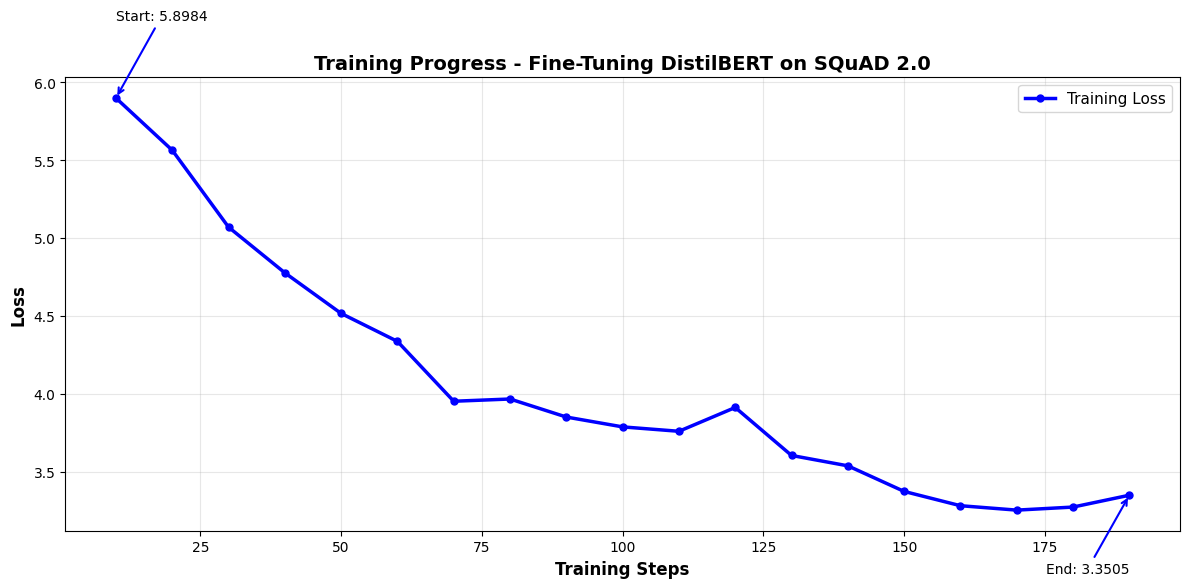


✅ Loss values are now properly tracked and visualized!

💡 What to look for:
  • Training loss should decrease steadily as the model learns
  • Steeper decline = faster learning
  • Leveling off = model has learned as much as it can


In [19]:
# Use the actual tracked losses (not the rounded ones from logger)
tracked_losses = loss_tracker.losses

print(f"📊 Plotting Training Progress:")
print(f"  • Number of loss entries: {len(tracked_losses)}")

if tracked_losses:
    steps = [l['step'] for l in tracked_losses]
    losses = [l['loss'] for l in tracked_losses]
    
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(steps, losses, 'b-', linewidth=2.5, marker='o', markersize=5, label='Training Loss')
    ax.set_xlabel('Training Steps', fontsize=12, fontweight='bold')
    ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
    ax.set_title('Training Progress - Fine-Tuning DistilBERT on SQuAD 2.0', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)
    
    # Add annotations
    ax.annotate(f'Start: {losses[0]:.4f}', 
                xy=(steps[0], losses[0]), 
                xytext=(steps[0], losses[0] + 0.5),
                fontsize=10, ha='left',
                arrowprops=dict(arrowstyle='->', color='blue', lw=1.5))
    
    ax.annotate(f'End: {losses[-1]:.4f}', 
                xy=(steps[-1], losses[-1]), 
                xytext=(steps[-1], losses[-1] - 0.5),
                fontsize=10, ha='right',
                arrowprops=dict(arrowstyle='->', color='blue', lw=1.5))
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Loss values are now properly tracked and visualized!")
else:
    print("\n⚠️ No losses to plot")

print("\n💡 What to look for:")
print("  • Training loss should decrease steadily as the model learns")
print("  • Steeper decline = faster learning")
print("  • Leveling off = model has learned as much as it can")

---

## Evaluate Fine-Tuned Model

Let's see how much the model improved! We'll compute:
- **Exact Match (EM)**: Percentage of predictions that exactly match ground truth
- **F1 Score**: Token-level overlap between prediction and ground truth

In [20]:
print("🔍 Evaluating fine-tuned model...\n")

# Get predictions from fine-tuned model
finetuned_predictions = trainer.predict(tokenized_test)

# Post-process to get answer texts
finetuned_answers = postprocess_qa_predictions(
    examples=test_subset,
    features=tokenized_test,
    predictions=(finetuned_predictions.predictions[0], finetuned_predictions.predictions[1])
)

# Calculate metrics
finetuned_em = compute_exact_match(finetuned_answers, references)
finetuned_f1 = compute_f1_score(finetuned_answers, references)

# Store results
eval_results_after = {'exact_match': finetuned_em, 'f1': finetuned_f1}

# Print comparison
print_training_summary(train_result, eval_results_before, eval_results_after)

The following columns in the test set don't have a corresponding argument in `DistilBertForQuestionAnswering.forward` and have been ignored: example_id, offset_mapping. If example_id, offset_mapping are not expected by `DistilBertForQuestionAnswering.forward`,  you can safely ignore this message.

***** Running Prediction *****
  Num examples = 201
  Batch size = 16

***** Running Prediction *****
  Num examples = 201
  Batch size = 16


🔍 Evaluating fine-tuned model...




FINE-TUNING RESULTS SUMMARY

📊 Training Statistics:
  • Total training time: 207.3 seconds
  • Training samples per second: 14.69
  • Final training loss: 4.0465

🎯 Performance Improvement:
  Before Fine-Tuning:
    - Exact Match (EM): 0.0%
    - F1 Score: 6.5%

  After Fine-Tuning:
    - Exact Match (EM): 8.0%
    - F1 Score: 15.7%

  📈 Improvement:
    - EM: +8.0%
    - F1: +9.2%

Key Insight: Fine-tuning on just 1,000 examples enabled the model to
learn task-specific skills while leveraging pretrained language knowledge!



---

## 🎓 Key Takeaways

### What We Learned

1. **Transfer Learning is Powerful**

2. **Architecture Matters**

3. **Fine-Tuning Best Practices**

4. **Computational Efficiency**

---

### 🚀 What's Next?

**To improve this Q&A system, you could:**
- Fine-tune on domain-specific data (medical, legal, technical)
- Use a larger model (BERT, RoBERTa) for better performance
- Implement confidence thresholds for "no answer" detection
- Add retrieval step for multi-document Q&A